In [165]:
import sys
import os
import mxnet as mx
import mxnet.ndarray as nd
import mxnet.gluon as gluon
import mxnet.gluon.nn as nn
import mxnet.autograd as ag
import symbol_utils

sys.path.append(os.path.join('..'))
from config import config

class ChannelAttentionBlock(nn.HybridBlock):

    def __init__(self, channel_size, **kwargs):

        super(ChannelAttentionBlock, self).__init__(**kwargs)
        with self.name_scope():
            self.net = nn.HybridSequential(prefix='')
            
            self.mean_block = nn.AvgPool2D()
            self.max_block = nn.MaxPool2D()
            
            self.mlp = nn.HybridSequential(prefix='')
            self.mlp.add(nn.Dense(units=channel_size))
            self.mlp.add(nn.Dense(units=channel_size//2))
            self.mlp.add(nn.Dense(units=channel_size))
    
    def hybrid_forward(self, F, x):
        
        mean_out = self.mean_block(x)
        max_out = self.max_block(x)
        
        y = self.mlp(mean_out) + self.mlp(max_out)
        
        return  F.Activation(y, "relu")

class SpatialAttentionBlock(nn.HybridBlock):

    def __init__(self, channel_size, **kwargs):

        super(SpatialAttentionBlock, self).__init__(**kwargs)
        with self.name_scope():
            
            self.net = nn.HybridSequential(prefix='')
            
            pool =gluon.contrib.nn.HybridConcurrent(1)
            pool.add(nn.AvgPool2D(pool_size=(channel_size,1),layout="NHWC"))
            pool.add(nn.MaxPool2D(pool_size=(channel_size,1),layout="NHWC"))
            
            self.net.add(pool)
            self.net.add(nn.Conv2D(1, kernel_size=7))

    def hybrid_forward(self, F, x):
        
        y = self.net(x)
        return  F.Activation(y, "relu")
    
    

# Helpers
def dense_block(num_layers, num_feature_maps, stage_index, transition=None):
    out = nn.HybridSequential(prefix='stage%d_' % stage_index)
    with out.name_scope():
        for _ in range(num_layers):
            out.add(dense_layer(num_feature_maps))

    return out


def dense_layer(feature_maps):
    
    dense = gluon.nn.HybridSequential()
    dense.add(nn.BatchNorm())
    dense.add(nn.LeakyReLU(0.3))
    dense.add(nn.Conv2D(feature_maps, kernel_size=3, padding=1, use_bias=False))
    dense.add(nn.Dropout(0.2))
    
    skip = gluon.contrib.nn.HybridConcurrent(1, prefix='')
    skip.add(gluon.contrib.nn.Identity())
    skip.add(dense)
    
    return skip

def transition_down(feature_maps):
    out = nn.HybridSequential(prefix='')
    out.add(nn.BatchNorm())
    out.add(nn.LeakyReLU(0.3))
    out.add(nn.Conv2D(feature_maps, kernel_size=1, use_bias=False))
    out.add(nn.Dropout(0.2))
    out.add(nn.MaxPool2D(pool_size=2))
    return out


def transition_up(feature_maps):
    out = nn.HybridSequential(prefix='')
    out.add(nn.Conv2DTranspose(feature_maps, kernel_size=6, padding=2, strides=2, use_bias=False))
    return out



class AttentionBlock(nn.HybridBlock):

    def __init__(self, num_feature_map, **kwargs):
        super(AttentionBlock, self).__init__(**kwargs)
        with self.name_scope():
            self.mean_block =  gluon.nn.HybridSequential()   
            self.mean_block.add(nn.AvgPool2D())
            self.mean_block.add(nn.Conv2D(num_feature_map, kernel_size=1, use_bias=False))
            self.mean_block.add(nn.LeakyReLU(0.3))
            self.mean_block.add(nn.Conv2D(num_feature_map, kernel_size=1, use_bias=False))

            self.max_block =  gluon.nn.HybridSequential()
            self.max_block.add(nn.MaxPool2D())
            self.max_block.add(nn.Conv2D(num_feature_map, kernel_size=1, use_bias=False))
            self.max_block.add(nn.LeakyReLU(0.3))
            self.max_block.add(nn.Conv2D(num_feature_map, kernel_size=1, use_bias=False))
            
        def hybrid_forward(self, F, x):
            mean_block_out = self.mean_block(x)
            max_block_out = self.max_block(x)

            return F.Activation(F.concat(mean_block_out, max_block_out), 'sigmoid')




/usr/local/lib/python3.6/dist-packages/mxnet/visualization.py:301: RuntimeWarning: There are multiple variables with the same name in your graph, this may result in cyclic graph. Repeated names: denselayer38_channelattentionblock0_dense2_fwd,denselayer38_channelattentionblock0_dense1_fwd,denselayer38_channelattentionblock0_dense0_fwd
  warnings.warn(warning_message, RuntimeWarning)


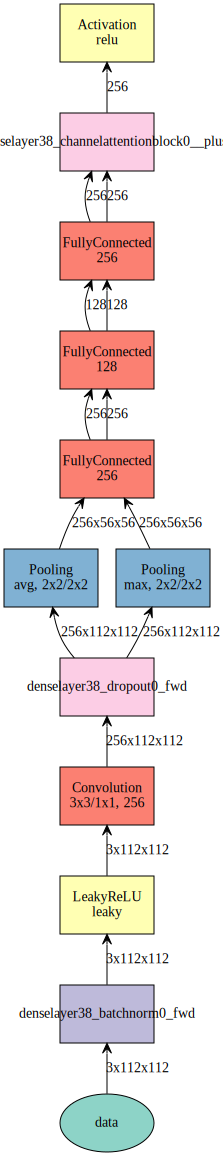

In [173]:
mx.viz.plot_network( net(mx.sym.var('data')), shape={'data':(1,3,112,112)})

In [1]:
import mxnet as mx
import mxnet.gluon.nn as nn
import mxnet.gluon as gluon

In [200]:
class DenseLayer(nn.HybridBlock):

    def __init__(self, feature_maps, **kwargs):
        super(DenseLayer, self).__init__(**kwargs)
        with self.name_scope():
            
            self.dense = gluon.nn.HybridSequential()
            self.dense.add(nn.BatchNorm())
            self.dense.add(nn.LeakyReLU(0.3))
            self.dense.add(nn.Conv2D(feature_maps, kernel_size=3, padding=1, use_bias=False))
            self.dense.add(nn.Dropout(0.2))

            self.channel_att = ChannelAttentionBlock(256)
            self.spatial_att = SpatialAttentionBlock(256)
            
    def hybrid_forward(self, F, x):
        x = self.dense(x)
        c = self.channel_att(x)
        x = F.broadcast_axis(mx.symbol.slice(c,begin=1), axis=2)
        return x

In [201]:
net = DenseLayer(256)
net.cast('float16')
mx.viz.print_summary(
    net(mx.sym.var('data')), 
    shape={'data':(1,256,26,26)}, #set your shape here
)

MXNetError: Required parameter end of Shape(tuple) is not presented, in operator slice(name="", begin="1")

In [31]:
import mxnet as mx
import symbol_utils
# Coded by Lin Xiong on Sep-25, 2018
# Referred to the pytorch code https://github.com/Youngkl0726/Convolutional-Block-Attention-Module/blob/master/CBAMNet.py, 
# More detailed information can be found in the following paper:
# Sanghyun Woo, Jongchan Park, Joon-Young Lee and In So Kweon, "CBAM: Convolutional Block Attention Module", ECCV 2018, https://arxiv.org/pdf/1807.06521v2.pdf
# We also refer the input setting and block setting of this paper II:
# Jiankang Deng, Jia Guo and Stefanos Zafeiriou, "ArcFace: Additive Angular Margin Loss for Deep Face Recognition", arXiv:1801.o7698v1
# The size of input faces is only 112x112 not 224x224
# We also refer the resnet-v2 version proposed in the following paper:
# Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. "Identity Mappings in Deep Residual Networks"

bn_mom = 0.9

# Basic layers
def BN(data, momentum=bn_mom, fix_gamma=False, eps=2e-5, name=None, suffix=''):
    bn = mx.sym.BatchNorm(data=data, name='%s%s_batchnorm' %(name, suffix), fix_gamma=fix_gamma, eps=eps, momentum=momentum, cudnn_off=True)
    # bn = mx.sym.BatchNorm(data=data, name='%s%s_batchnorm' %(name, suffix), fix_gamma=fix_gamma, eps=eps, momentum=momentum)
    return bn

def Act(data, act_type='prelu', name=None):
    body = mx.sym.LeakyReLU(data = data, act_type=act_type, name = '%s_%s' %(name, act_type))
    #body = mx.sym.Activation(data=data, act_type='relu', name=name)
    return body

def Conv(data, num_filter=1, kernel=(1, 1), stride=(1, 1), pad=(0, 0), num_group=1, workspace=256, name=None, w=None, b=None, suffix=''):
    if w is None:
        conv = mx.sym.Convolution(data=data, num_filter=num_filter, kernel=kernel, num_group=num_group, stride=stride, pad=pad, no_bias=True, workspace=workspace, name='%s%s_conv2d' %(name, suffix))
    else:
        if b is None:
            conv = mx.sym.Convolution(data=data, num_filter=num_filter, kernel=kernel, num_group=num_group, stride=stride, pad=pad, no_bias=True, workspace=workspace, weight=w, name='%s%s_conv2d' %(name, suffix))
        else:
            conv = mx.sym.Convolution(data=data, num_filter=num_filter, kernel=kernel, num_group=num_group, stride=stride, pad=pad, workspace=workspace, weight=w, bias=b, name='%s%s_conv2d' %(name, suffix))
    return conv

def BN_Act(data, momentum=bn_mom, name=None, suffix=''):
    bn = BN(data, momentum=momentum, fix_gamma=False, eps=2e-5, name=name, suffix=suffix)
    bn_act = Act(bn, act_type='prelu', name=name)
    return bn_act

def BN_Conv(data, num_filter=1, kernel=(1, 1), stride=(1, 1), pad=(0, 0), num_group=1, momentum=bn_mom, workspace=256, name=None, w=None, b=None, suffix=''):
    bn = BN(data, momentum=momentum, fix_gamma=False, eps=2e-5, name=name, suffix=suffix)
    bn_conv = Conv(bn, num_filter=num_filter, kernel=kernel, stride=stride, pad=pad, num_group=num_group, workspace=workspace, name=name, w=w, b=b, suffix=suffix)
    return bn_conv

def BN_Act_Conv(data, num_filter=1, kernel=(1, 1), stride=(1, 1), pad=(0, 0), num_group=1, momentum=bn_mom, workspace=256, name=None, w=None, b=None, suffix=''):
    bn = BN(data, momentum=momentum, fix_gamma=False, eps=2e-5, name=name, suffix=suffix)
    bn_act = Act(bn, act_type='prelu', name=name)
    bn_act_conv = Conv(bn_act, num_filter=num_filter, kernel=kernel, stride=stride, pad=pad, num_group=num_group, workspace=workspace, name=name, w=w, b=b, suffix=suffix)
    return bn_act_conv



# Convolutional Block Attention Module (CBAM)
def CBAM(data, num_filter, reduction, act_type, workspace, name, suffix=''):
    # Channel attention module
    module_input = data
    avg = mx.sym.Pooling(data=data, global_pool=True, kernel=(7, 7), pool_type='avg', name='%s_ca_avg_pool1' %(name))
    ma  = mx.sym.Pooling(data=data, global_pool=True, kernel=(7, 7), pool_type='max', name='%s_ca_max_pool1' %(name))
    # import pdb
    # pdb.set_trace()
    avg = Conv(avg, num_filter=num_filter//reduction, kernel=(1, 1), stride=(1, 1), pad=(0, 0), num_group=1, workspace=workspace, name='%s_ca_avg_fc1' %(name), suffix='')
    ma  = Conv(ma, num_filter=num_filter//reduction, kernel=(1, 1), stride=(1, 1), pad=(0, 0), num_group=1, workspace=workspace, name='%s_ca_max_fc1' %(name), suffix='')
    # import pdb
    # pdb.set_trace()
    avg = Act(avg, act_type=act_type, name='%s_ca_avg_%s' %(name, act_type))
    ma  = Act(ma, act_type=act_type, name='%s_ca_max_%s' %(name, act_type))
    avg = Conv(avg, num_filter=num_filter, kernel=(1, 1), stride=(1, 1), pad=(0, 0), num_group=1, workspace=workspace, name='%s_ca_avg_fc2' %(name), suffix='')
    ma  = Conv(ma, num_filter=num_filter, kernel=(1, 1), stride=(1, 1), pad=(0, 0), num_group=1, workspace=workspace, name='%s_ca_max_fc2' %(name), suffix='')
    # import pdb
    # pdb.set_trace()
    body = avg + ma
    body = mx.symbol.Activation(data=body, act_type='sigmoid', name='%s_ca_sigmoid' %(name))
    # Spatial attention module
    body = mx.symbol.broadcast_mul(module_input, body)
    # import pdb
    # pdb.set_trace()
    module_input = body
    avg = mx.symbol.mean(data=body, axis=1, keepdims=True, name='%s_sa_mean' %(name))
    ma  = mx.symbol.max(data=body, axis=1, keepdims=True, name='%s_sa_max' %(name))
    # import pdb
    # pdb.set_trace()
    body = mx.symbol.Concat(avg, ma, dim=1, name='%s_sa_concat' %(name))
    body = Conv(body, num_filter=1, kernel=(3, 3), stride=(1, 1), pad=(1, 1), num_group=1, workspace=workspace, name='%s_sa_conv' %(name), suffix='')
    body = mx.symbol.Activation(data=body, act_type='sigmoid', name='%s_sa_sigmoid' %(name))
    body = mx.symbol.broadcast_mul(module_input, body)
    return body

# Instance-batch normalization (IBN) block
def IBN_block(data, num_filter, name, eps=2e-5, bn_mom=0.9, suffix=''):
    split = mx.symbol.split(data=data, axis=1, num_outputs=2)
    # import pdb
    # pdb.set_trace()
    out1 = mx.symbol.InstanceNorm(data=split[0], eps=eps, name=name + '_ibn' + '_in1')
    out2 = BN(split[1], momentum=bn_mom, fix_gamma=False, eps=eps, name=name + '_ibn', suffix=suffix)
    out = mx.symbol.Concat(out1, out2, dim=1, name=name + '_ibn1')
    return out

def CBAM_Residual_unit(data, num_filter, reduction, stride, dim_match, name, bottle_neck):
    # Improved resnet bottleneck with a CBAM module. It follows the paper "ArcFace: Additive Angular Margin Loss for Deep Face Recognition". 
    # We also refer the paper "Identity Mappings in Deep Residual Networks".
    bn_mom = 0.9
    workspace = 256
    eps = 2e-5
    reduction = 16
    act_type = 'prelu'
    memonger = False
    
    bn1 = BN(data, momentum=bn_mom, fix_gamma=False, eps=eps, name='%s_c3x3' %(name), suffix='')
    conv1 = Conv(bn1, num_filter=num_filter, kernel=(3, 3), stride=(1, 1), pad=(1, 1), num_group=1, workspace=workspace, name='%s_c3x3_a' %(name), suffix='')
    conv2 = BN_Act_Conv(conv1, num_filter=num_filter, kernel=(3, 3), stride=stride, pad=(1, 1), num_group=1, 
                                     momentum=bn_mom, workspace=workspace, name='%s_c3x3_b' %(name))
    conv2 = BN(conv2, momentum=bn_mom, fix_gamma=False, eps=eps, name='%s_bn_c3x3_b' %(name))
    conv2 = CBAM(conv2, num_filter, reduction, act_type, workspace, name='%s_cbam' %(name))

    if dim_match:
        shortcut = data
    else:
        conv1sc = Conv(data, num_filter=num_filter, kernel=(1, 1), stride=stride, pad=(0, 0), num_group=1, workspace=workspace, name='%s_conv1sc' %(name), suffix='')
        shortcut = BN(conv1sc, momentum=bn_mom, fix_gamma=False, eps=eps, name='%s_bn_sc' %(name))
    
    if memonger:
        shortcut._set_attr(mirror_stage='True')
    return mx.symbol.Concat(conv2, shortcut, dim=1, name='%s_concat' %(name))


def CBAMNet(units, num_stages, filter_list, bottle_neck):
    global bn_mom
    workspace = 256
    eps = 2e-5
    bn_mom = 0.9
    input_shape = None
    reduction = 16
    version_input = 1
    assert version_input>=0
    version_output ='E'
    fc_type = version_output
    act_type = 'prelu'

    num_unit = len(units)
    assert(num_unit == num_stages)
    
    data = mx.sym.Variable(name='data', shape=input_shape)
    data = mx.sym.identity(data=data, name='id')
    data = data-127.5
    data = data*0.0078125
    
    body = Conv(data, filter_list[0], kernel=(7, 7), stride=(2, 2), pad=(3, 3), num_group=1, workspace=workspace, name='cbam_conv1')
    body = BN_Act(body, momentum=bn_mom, name='cbam_conv1_bn1')
    body = mx.sym.Pooling(data=body, kernel=(3, 3), stride=(2, 2), pad=(1,1), pool_type='max')

    body._set_attr(mirror_stage='True')

    for i in range(num_stages):
      if version_input==0:
        body = CBAM_Residual_unit(body, filter_list[i+1], reduction, (1 if i==0 else 2, 1 if i==0 else 2), False,
                             name='stage%d_unit%d' % (i + 1, 1), bottle_neck=bottle_neck
                                 )
      else:
        body = CBAM_Residual_unit(body, filter_list[i+1], reduction, (2, 2), False,
          name='stage%d_unit%d' % (i + 1, 1), bottle_neck=bottle_neck)
      body._set_attr(mirror_stage='True')
      for j in range(units[i]-1):
        body = CBAM_Residual_unit(body, filter_list[i+1], reduction, (1, 1), True, name='stage%d_unit%d' % (i+1, j+2),
          bottle_neck=bottle_neck)
        # import pdb
        # pdb.set_trace()
        body._set_attr(mirror_stage='True')


    return body

In [32]:
num_layers= 90
units = [3, 8, 30, 3]
filter_list = [64, 64, 128, 256, 512]
bottle_neck = False
num_stages = 4
net = CBAMNet(units= units,num_stages  = num_stages,filter_list = filter_list,bottle_neck = bottle_neck)


In [33]:
mx.viz.print_summary(net, 
    shape={'data':(1,3,112,112)}, #set your shape here
)

________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
data(null)                                          3x112x112               0                                           
________________________________________________________________________________________________________________________
id(_copy)                                           3x112x112               0           data                            
________________________________________________________________________________________________________________________
_minusscalar7(_minus_scalar)                        3x112x112               0           id                              
________________________________________________________________________________________________________________________
_mulscalar7(_mul_scalar)        

stage3_unit20_cbam_sa_max(max)                      1x4x4                   0           broadcast_mul414                
________________________________________________________________________________________________________________________
stage3_unit20_cbam_sa_concat(Concat)                2x4x4                   0           stage3_unit20_cbam_sa_mean      
                                                                                        stage3_unit20_cbam_sa_max       
________________________________________________________________________________________________________________________
stage3_unit20_cbam_sa_conv_conv2d(Convolution)      1x4x4                   18          stage3_unit20_cbam_sa_concat    
________________________________________________________________________________________________________________________
stage3_unit20_cbam_sa_sigmoid(Activation)           1x4x4                   0           stage3_unit20_cbam_sa_conv_conv2
________________________________

In [34]:
mx.viz.plot_network( net, shape={'data':(1,3,112,112)})